# Informações

Nome: Francisco Altanizio Batista de Castro Junior

Matrícula: 575220

Curso: ENGENHARIA DE TRANSPORTES

Disciplina: CKP8277 - APRENDIZAGEM AUTOMÁTICA

In [108]:
import numpy as np  # para operações
import matplotlib.pyplot as plt  # para plotagem
import seaborn as sns  # para plotagem
import pandas as pd  # para algumas poucas manipulações

In [109]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self, X):
        return X * self.std + self.mean

## Questão 1

Considere o conjunto de dados disponível em `quake.csv`, organizado em 2 colunas de atributos. Os dados referem-se a latitudes e longitudes de locais em que foram registrados terremotos. Maiores detalhes sobre os dados podem ser conferidos em:  
[https://www.openml.org/d/772](https://www.openml.org/d/772).



In [110]:
class KMeans:
    """
    Modelo K-Means

    - k: número de clusters.
    - dist: métrica de distância utilizada. Pode ser 'euclidiana' ou 'mahalanobis'.
    """

    def __init__(self, k=1, dist="euclidiana", seed = 1):
        self.k = k
        self.dist = dist
        self.centroids = None
        self.labels = None
        self.erro = None
        self.seed = seed

    def fit(self, X, max_iter=1000):
        N, _ = X.shape
        my_random = np.random.default_rng(seed=self.seed)
        indices = my_random.choice(N, self.k, replace=False)
        self.centroids = X[indices]

        if self.dist == "mahalanobis":
            cov = np.cov(X.T)
            inv_cov = np.linalg.inv(cov)

        for _ in range(max_iter):
            if self.dist == "euclidiana":
                dists = (
                    -2 * X @ self.centroids.T
                    + np.sum(self.centroids**2, axis=1)
                    + np.sum(X**2, axis=1)[:, np.newaxis]
                )

            elif self.dist == "mahalanobis":
                dists = np.zeros((N, self.k))
                for i in range(N):
                    for j in range(self.k):
                        diff = X[i] - self.centroids[j]
                        dists[i, j] = np.sqrt(diff.T @ inv_cov @ diff)

            else:
                raise ValueError(
                    "Distância não reconhecida. Use 'euclidiana' ou 'mahalanobis'."
                )

            labels = np.argmin(dists, axis=1)

            new_centroids = np.array(
                [
                    X[labels == i].mean(axis=0)
                    if np.any(labels == i)
                    else self.centroids[i]
                    for i in range(self.k)
                ]
            )

            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids
            self.erro = np.sum(np.min(dists, axis=1))

        self.labels = labels

    def davies_bouldin_index(self, X):
        k = self.k
        centroids = self.centroids
        labels = self.labels

        if self.dist == "mahalanobis":
            cov = np.cov(X.T)
            inv_cov = np.linalg.inv(cov)

        S = np.zeros(k)
        for i in range(k):
            cluster_i = X[labels == i]
            if cluster_i.shape[0] > 0:
                if self.dist == "euclidiana":
                    dists = np.linalg.norm(cluster_i - centroids[i], axis=1)
                elif self.dist == "mahalanobis":
                    dists = np.array(
                        [
                            np.sqrt((x - centroids[i]).T @ inv_cov @ (x - centroids[i]))
                            for x in cluster_i
                        ]
                    )
                S[i] = np.mean(dists)

        M = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                if i != j:
                    if self.dist == "euclidiana":
                        M[i, j] = np.linalg.norm(centroids[i] - centroids[j])
                    elif self.dist == "mahalanobis":
                        diff = centroids[i] - centroids[j]
                        M[i, j] = np.sqrt(diff.T @ inv_cov @ diff)

        R = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                if i != j:
                    R[i, j] = (S[i] + S[j]) / M[i, j]

        D = np.max(R, axis=1)
        dbi = np.mean(D)

        return dbi

In [111]:
def select_melhor_k(data, k_range=range(4, 21), repets=20, dist_sel="euclidiana"):
    melhor_modelo = None
    menor_erro = np.inf
    melhor_dbi_por_k = []
    melhor_erro_por_k = []
    k_list = []
    melhores_modelos = []

    for k in k_range:
        for i in range(repets):
            modelo = KMeans(k=k, dist=dist_sel, seed=i)
            modelo.fit(data)

            if modelo.erro < menor_erro:
                menor_erro = modelo.erro
                melhor_modelo = modelo

        dbi = melhor_modelo.davies_bouldin_index(data)
        melhor_dbi_por_k.append(dbi)
        melhor_erro_por_k.append(menor_erro)
        k_list.append(k)
        melhores_modelos.append(melhor_modelo)

        print(f"k={k}, DBI={dbi:.4f}, Erro={menor_erro:.4f}")

    return k_list, melhor_dbi_por_k, melhor_erro_por_k, melhores_modelos

In [112]:
data = np.genfromtxt("quake.csv", delimiter=",")

In [113]:
data.shape

(2178, 2)

In [114]:
data_standard = StandardScaler()
data = data_standard.fit_transform(data)

### **a)** Avalie o algoritmo K-médias com distância Euclidiana na tarefa de agrupamento para tais dados. O número de grupos deve ser escolhido entre os valores `4, 5, 6, ..., 19, 20` a partir do índice DB (Davies-Bouldin). Plote o melhor resultado de agrupamento obtido.  
**Observação:** Em cada avaliação, repita múltiplas vezes (por exemplo, 20) a execução do algoritmo K-médias, escolhendo a solução com melhor erro de reconstrução.

In [115]:
k_list, melhor_dbi_por_k, melhor_erro_por_k, melhores_modelos = select_melhor_k(
    data, k_range=range(4, 21), repets=20, dist_sel="euclidiana"
)

k=4, DBI=0.6140, Erro=723.6092
k=5, DBI=0.6611, Erro=595.3017
k=6, DBI=0.6197, Erro=470.9789
k=7, DBI=0.6346, Erro=385.7350
k=8, DBI=0.6954, Erro=320.2322
k=9, DBI=0.6524, Erro=255.7038
k=10, DBI=0.6118, Erro=211.8809
k=11, DBI=0.6249, Erro=181.4813
k=12, DBI=0.5890, Erro=157.0834
k=13, DBI=0.6665, Erro=145.0062
k=14, DBI=0.6030, Erro=131.8016
k=15, DBI=0.6582, Erro=119.8798
k=16, DBI=0.6467, Erro=109.4745
k=17, DBI=0.6172, Erro=105.3792
k=18, DBI=0.6395, Erro=99.5426
k=19, DBI=0.6218, Erro=88.6494
k=20, DBI=0.7229, Erro=86.9741


In [116]:
data_pd = pd.DataFrame(
    {"k": range(4, 21), "DBI": melhor_dbi_por_k, "erro": melhor_erro_por_k}
)

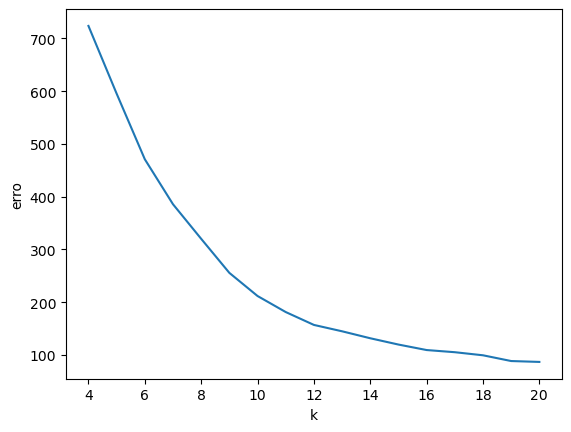

In [117]:
sns.lineplot(data=data_pd, x="k", y="erro")
plt.show()

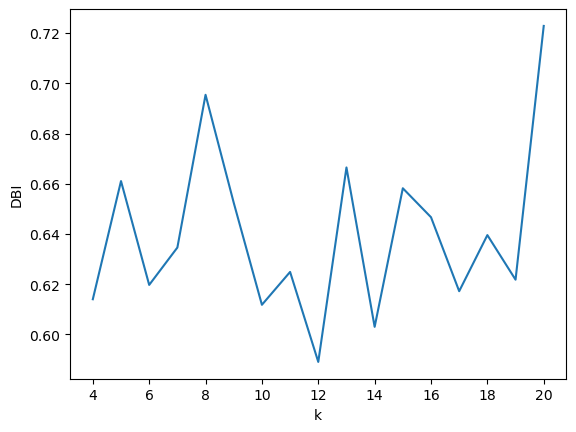

In [118]:
sns.lineplot(data=data_pd, x="k", y="DBI")
plt.show()

In [119]:
idx_melhor_k = np.argmin(melhor_dbi_por_k)
melhor_k = k_list[idx_melhor_k]
melhor_modelo_final = melhores_modelos[idx_melhor_k]

In [120]:
melhor_k

12

In [121]:
melhor_modelo_final.centroids

array([[ 1.09647598,  0.04668121],
       [ 1.23466269,  0.80257805],
       [-1.02142932, -1.93058737],
       [-0.14989071,  0.52032478],
       [-2.12021079, -0.73892439],
       [-1.03015995, -1.06287649],
       [ 0.07635165, -1.11256849],
       [ 2.11839574, -0.062624  ],
       [ 0.61221314,  0.60667624],
       [ 1.47974007, -1.7573846 ],
       [-0.56356197,  0.80225636],
       [-1.63373313,  0.77137652]])

In [123]:
melhor_modelo_final.davies_bouldin_index(data)

np.float64(0.5890369056215455)

In [124]:
data_pd = pd.DataFrame(data, columns=["lat", "long"])

In [125]:
data_pd["cluster"] = melhor_modelo_final.labels

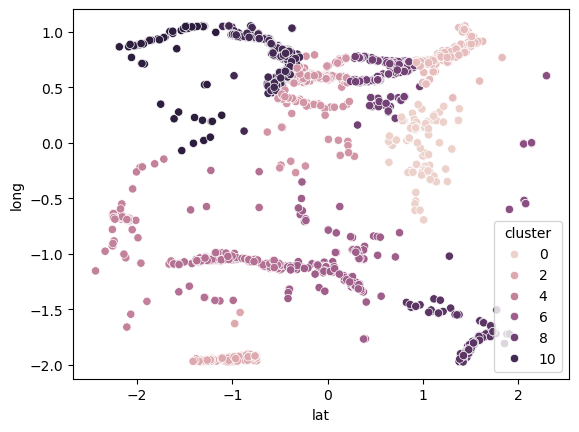

In [126]:
sns.scatterplot(data=data_pd, x="lat", y="long", hue="cluster")
plt.show()

### **b)** Repita o item anterior considerando a distância de Mahalanobis.  
**Observação:** Note que o índice DB deve ser alterado para usar a distância de Mahalanobis neste item.

In [ ]:
k_list, melhor_dbi_por_k, melhor_erro_por_k, melhores_modelos = select_melhor_k(
    data, k_range=range(4, 21), repets=20, dist_sel="mahalanobis"
)

k=4, DBI=0.5913, Erro=1089.2838
k=5, DBI=0.6434, Erro=1005.2624
k=6, DBI=0.5471, Erro=860.9788
k=7, DBI=0.6210, Erro=796.2748
k=8, DBI=0.6859, Erro=693.7572
k=9, DBI=0.6540, Erro=627.6017
k=10, DBI=0.6430, Erro=585.9113
k=11, DBI=0.6169, Erro=538.7164
k=12, DBI=0.6409, Erro=500.9007
k=13, DBI=0.6225, Erro=460.7206
k=14, DBI=0.5712, Erro=439.4738
k=15, DBI=0.6608, Erro=413.6178
k=16, DBI=0.6030, Erro=400.3752
k=17, DBI=0.7374, Erro=391.2047
k=18, DBI=0.6649, Erro=369.1345
k=19, DBI=0.5905, Erro=349.7928
k=20, DBI=0.6314, Erro=336.7584


In [697]:
data_pd = pd.DataFrame(
    {"k": range(4, 21), "DBI": melhor_dbi_por_k, "erro": melhor_erro_por_k}
)

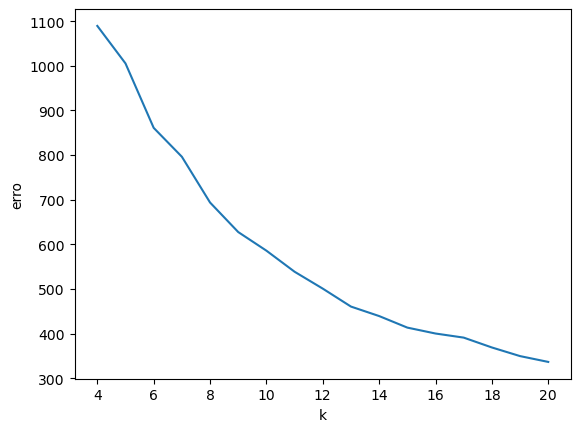

In [698]:
sns.lineplot(data=data_pd, x="k", y="erro")
plt.show()

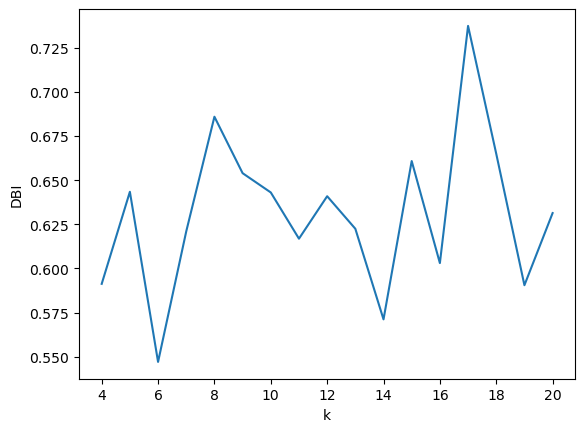

In [699]:
sns.lineplot(data=data_pd, x="k", y="DBI")
plt.show()

In [700]:
idx_melhor_k = np.argmin(melhor_dbi_por_k)
melhor_k = k_list[idx_melhor_k]
melhor_modelo_final = melhores_modelos[idx_melhor_k]

In [701]:
melhor_k

6

In [702]:
melhor_modelo_final.centroids

array([[ 1.49686632, -1.72009519],
       [ 1.0531387 ,  0.49641451],
       [-1.56673174, -0.90627886],
       [-0.50879794,  0.7233465 ],
       [-1.02276681, -1.92221568],
       [-0.0997584 , -1.08115578]])

In [703]:
melhor_modelo_final.labels

array([2, 1, 1, ..., 1, 1, 1], shape=(2178,))

In [704]:
melhor_modelo_final.davies_bouldin_index(data)

np.float64(0.5470529452369336)

In [705]:
data_pd = pd.DataFrame(data, columns=["lat", "long"])

In [ ]:
data_pd["cluster"] = melhor_modelo_final.labels

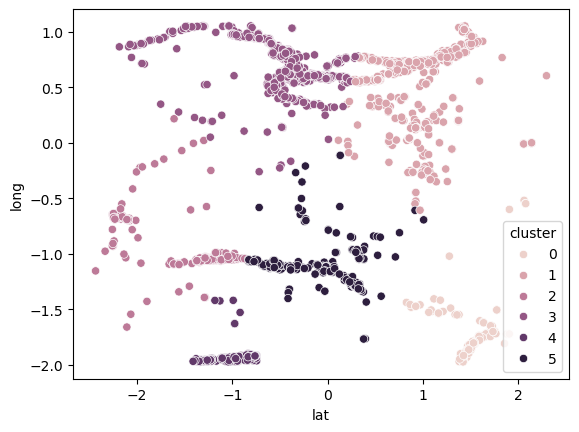

In [ ]:
sns.scatterplot(data=data_pd, x="lat", y="long", hue="cluster")
plt.show()

# Questão 2

Considere o conjunto de dados disponível em `penguins.csv`, organizado em 5 colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados referem-se a medições anatômicas de pinguins da Antártida, classificados nas espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem ser conferidos em:  
[https://allisonhorst.github.io/palmerpenguins/](https://allisonhorst.github.io/palmerpenguins/).


In [127]:
class PCA:
    def __init__(self, dim):
        self.dim = dim
        self.componentes = None
        self.var_explicada_perc = None

    def fit(self, X):
        _, S, VT = np.linalg.svd(X, full_matrices=False)
        self.componentes = VT[: self.dim]
        var_explicada = (S**2) / (X.shape[0] - 1)
        total_variancia = np.sum(var_explicada)
        self.var_explicada_perc = var_explicada[: self.dim] / total_variancia

    def transform(self, X):
        return np.dot(X, self.componentes.T)

In [128]:
data = np.genfromtxt("penguins.csv", delimiter=",")

In [129]:
data.shape

(333, 5)

In [130]:
X = data[:, :4]

In [131]:
X.shape

(333, 4)

In [132]:
X = StandardScaler().fit_transform(X)

## **a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

In [133]:
my_pca = PCA(dim=2)

In [134]:
my_pca.fit(X)

In [137]:
my_pca.var_explicada_perc

array([0.68633893, 0.19452929])

In [138]:
X_transformed = my_pca.transform(X)

In [139]:
data_pca = np.concat([X_transformed, data[:, [4]]], axis=1)

In [140]:
data_pd = pd.DataFrame(data_pca, columns=["PC1", "PC2", "y"])

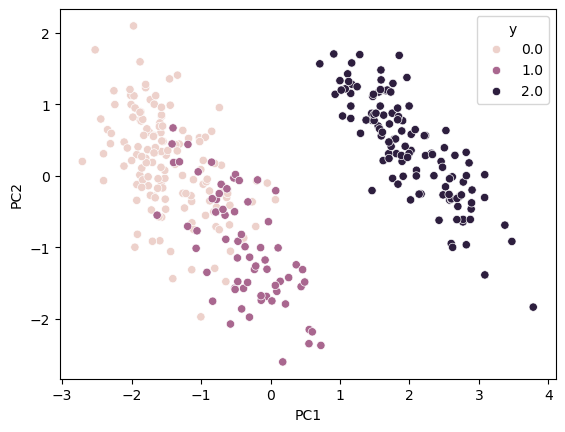

In [141]:
sns.scatterplot(data=data_pd, x="PC1", y="PC2", hue="y")
plt.show()

## **b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1, 2, 3 ou 4).  

In [143]:
var_list = []
for i in range(1, 5):
    pca = PCA(dim=i)
    pca.fit(X)
    var_list.append((i, np.sum(pca.var_explicada_perc)))

In [144]:
var_list

[(1, np.float64(0.6863389313599902)),
 (2, np.float64(0.880868224204992)),
 (3, np.float64(0.9730288540858754)),
 (4, np.float64(1.0))]

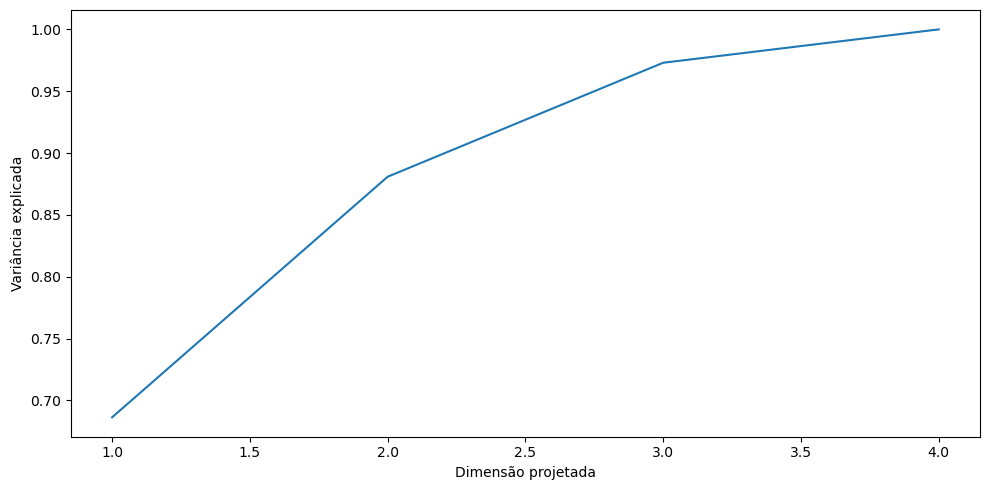

In [145]:
dim, expvar = zip(*var_list)
plt.figure(figsize=(10, 5))
sns.lineplot(x=dim, y=expvar)
plt.xlabel("Dimensão projetada")
plt.ylabel("Variância explicada")
plt.tight_layout()
plt.show()